# Validation Notebook for My Candidate ReRank Model
In this notebook, we attempted to develop a two-stage model which includes the candidate generation model (Covisitation Matrix) and Ranking Model. 
This practice is widely used in big tech company since the candidate generation 

It should be noted that the candidate generation model should target for high recall while the ranking model should target for to rank the most relevent item first.


# Introduction of Notebook


## Step 1: Model Training
### Step 1.1 - Loading Training Data
The training data in this notebook is extracted by this logic: <br>
`train_df = train_df[train_df['session']%10 == 1]` <br>

The label of the training data is stored in the test_labels.parquet, which **contain the label for both training and testing data (For quick experimet only).**


### Step 1.2 - Feature Engineering on Training Data
All the feature is pre-calculated and saved in parquet files. All parquet file is saved in this kaggle dataset `/kaggle/input/otto-validation` <br>
Here we only do a simple joining between the training data & pre-calculated features


### Step 1.3 - Model Training on Training data
We train the LGBM ranking using the training data.

<br>

## Step 2: Model Inference
### Step 2.1 - Loading testing data
The training data in this notebook is extracted by this logic: <br>
`test_df = test_df[test_df['session']%10 == 0]`


### Step 2.2 - Generate Candidates
We use the logic from the Chris Deotte's Candidate ReRank Model to generate 40 potential candidates. We have pre-calculated all the co-visitation dictionary and saved in the kaggle dataset 
`/kaggle/input/otto-covisitation-matrix-parquet-files` <br>
In this stage, we will generate 40 candidates per session and pass into the ranker for the final ranking. <br>

Please refer to Chris notebook for detailed logic explaination
https://www.kaggle.com/code/cdeotte/candidate-rerank-model-lb-0-575 <br>

### Step 2.3 - Ranker Model
1. The recommmended aid from the candidate generation phase will merge with the test aid for ranking.
2. Feature preprocessing step is exactly the same with the training pipeline
3. The test dataframe will be passed for prediction and the scores will be merged with the dataframe
4. Sort each session in the dataframe by score from high to low
5. Using `groupby('session').last(20) to extract top 20 result


### Step 2.4 - Export to CSV
<br>

## Step 3: Model Evaluation
Same logic with the Chris notebook: https://www.kaggle.com/code/cdeotte/compute-validation-score-cv-565

# Credits
1. The validation part of the notebook comes from Chris Deotte Notebook: https://www.kaggle.com/code/cdeotte/compute-validation-score-cv-565 <br>
2. The covisition matrix calculation comes from Chris Deotte Notebook: https://www.kaggle.com/code/cdeotte/candidate-rerank-model-lb-0-575 <br>
3. The code of LGBM ranker is inspired by RADEK OSMULSKI in his Notebook: https://www.kaggle.com/code/radek1/polars-proof-of-concept-lgbm-ranker <br>

# Important Note!
This notebook is still in development phase so it is using the local validation dataset instead of the full training and testing dataset

In [1]:
from typing import Tuple
import numpy as np
import pandas as pd
import polars as pl
from omegaconf import DictConfig, OmegaConf
import hydra
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
import pathlib
from annoy import AnnoyIndex
from gensim.models import Word2Vec
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')
import itertools
from collections import Counter
from pandarallel import pandarallel
pandarallel.initialize(
    progress_bar=True,
    nb_workers=10,
)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
initialize(config_path="../conf", job_name="features_app")
config = compose(config_name="config", overrides=[
                                                    "data_path=../data/", 
                                                    "validation_path=../data/local_validation/", 
                                                    "artifact_path=../artifacts/",
                                                    "model_path=../models/",
                                                    ]
                                                )
print(OmegaConf.to_yaml(config))

name: n_tree 100 for build index with window of 5
tags:
- window length
- n_tree
- word2vec
description: n_tree 100 for build index with window of 5
data_path: ../data/
validation_path: ../data/local_validation/
artifact_path: ../artifacts/
debug: false
local_validation: true
word2vec: true
train_file: train.parquet
test_file: test.parquet
test_labels_file: test_labels.parquet
submission_path: submissions/
submission_file: submission.csv
model_path: ../models/
curr_model_path: models/word2vec.model
type_labels:
  clicks: 0
  carts: 1
  orders: 2
type_weight:
  0: 0.5
  1: 9
  2: 0.5
version: 1
chunk_size: 200000
random_state: 42
fraction: 0.002
n_top: 15
n_top_clicks: 20
n_samples: 50
time_diff: 7 * 24 * 60 * 60
one_week: 7 * 24 * 60 * 60
vector_size: 100
window: 5
negative: 20
workers: 12
epochs: 2
min_count: 5
n_trees: 100
n_recent: 2



# Step 1: Model Training

## Step 1.1 - Generate Training Data

There are two types of aid we will reocommned to the users: 
1. Data from the training data set (Actual aid in the dataset [i.e. the actual behavior of the user. User may cart the item that they clicked or they may click again for same item])
2. Data from candiate generation (Recommended aid from the candidate generation logic [i.e. The item that is related to the actual user behavior])

Therefore, our ranker should be able to rank these two items at the same time.

We want to simulate the this data for inference time with recommended candidates. Therefore, we need to generate some recommended item  in the training size to make sure training set has same distribution as inference time. <br>


### Generating Training data from the test set (Actual behavior)

In [3]:
# Getting the actual aid from dataset

type_ranker = 2

def load_train_data_sampled():    
    
    train_df = pd.read_parquet(f'{config.validation_path}test.parquet')

    # Using different sample as the candidate generation for training
    train_df = train_df[train_df['session']%10 == 1]
    return train_df

train_df = load_train_data_sampled()
print('Sampled Training data has shape',train_df.shape)


# This indicate that this aid is actual behaviors
train_df['real_action'] = 1

# CG stands for candidate generation. Since the aid here is actual user behavior, they should have no ranking
train_df['CG_ranking'] = 0

# Only focus on click action first
train_df_click = train_df[train_df['type'] == type_ranker]

# Calculate the last three aid for the embedding calculation
# train_df_click['aid_last'] = train_df_click.groupby(['session']).aid.shift(1).bfill()
# train_df_click['aid_second_last'] = train_df_click.groupby(['session']).aid.shift(2).bfill()
# train_df_click['aid_third_last'] = train_df_click.groupby(['session']).aid.shift(3).bfill()

Sampled Training data has shape (768762, 4)


In [4]:
train_df_click

,session,aid,ts,type,real_action,CG_ranking
28,11098531,1728212,1661119746,2,1,0
29,11098531,452188,1661119746,2,1,0
30,11098531,1271998,1661119746,2,1,0
31,11098531,396199,1661119746,2,1,0
428,11098571,1523498,1661119905,2,1,0
...,...,...,...,...,...,...
7666368,12893791,1791730,1661721147,2,1,0
7669756,12894931,830715,1661721911,2,1,0
7674818,12896501,1817803,1661722298,2,1,0
7674819,12896501,1094444,1661722298,2,1,0


In [5]:
train_df_click = pl.from_pandas(train_df_click)

In [6]:
# train_df_click = train_df_click.with_columns([
#     pl.col('aid_last').cast(pl.Int32),
#     pl.col('aid_second_last').cast(pl.Int32),
#     pl.col('aid_third_last').cast(pl.Int32),
# ])

In [7]:
def get_top_clicks_orders(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    top_clicks = (
        df.loc[df["type"] == config.type_labels["clicks"], "aid"]
        .value_counts()
        .index.values[:20]
    )
    top_orders = (
        df.loc[df["type"] == config.type_labels["orders"], "aid"]
        .value_counts()
        .index.values[:20]
    )
    return top_clicks, top_orders


def load_combined_covisitation(type: str = "clicks") -> pd.DataFrame:
    top_20 = pd.read_pickle(
        f"{config.data_path}top_20_{type}_v{config.version}.pkl"
    )
    print(f"Size of top_20_{type}:", len(top_20))
    return top_20


def get_nns(
    model: Word2Vec,
    index: AnnoyIndex,
    product: str,
    aid2idx: Dict[str, int],
    n: int = 21,
) -> List[str]:
    """Get nearest neighbors for a given aid."""
    try:
        idx = aid2idx[product]
        nns = index.get_nns_by_item(idx, n)[1:]
        nns = [model.wv.index_to_key[idx] for idx in nns]
    except Exception:
        nns = []
    return nns


def load_model():
    """Load word2vec model."""
    if not config.word2vec:
        return None
    print("Loading word2vec model...")
    model = Word2Vec.load(f"{config.model_path}word2vec_windowl_{config.window}.model")
    print(
        f"Model loaded from path: {config.model_path}word2vec_windowl_{config.window}.model"
    )
    return model


def build_index(model) -> Tuple[AnnoyIndex, Dict[str, int]]:
    """Build index for word2vec model."""
    if not config.word2vec:
        return None, None
    print("Building index for word2vec model...")
    aid2idx = {aid: i for i, aid in enumerate(model.wv.index_to_key)}
    index = AnnoyIndex(model.wv.vector_size, metric="euclidean")
    for idx in aid2idx.values():
        index.add_item(idx, model.wv.vectors[idx])
    index.build(n_trees=config.n_trees)
    return index, aid2idx

# global index, aid2idx, model
# model = load_model()
# index, aid2idx = build_index(model)

### Generating Training data from candidate generation

The below block of code is exactly the same code we used for candidate generation based on the candidate ReRank Model. <br>
You may refer here for the detailed logic: https://www.kaggle.com/code/cdeotte/candidate-rerank-model-lb-0-575

In [8]:
%%time
top_clicks, top_orders = get_top_clicks_orders(train_df)
covisit_clicks = load_combined_covisitation(type="clicks")
covisit_carts_orders = load_combined_covisitation(type="carts-orders")
covisits_buy2buy = load_combined_covisitation(type="buy2buy")

def suggest_clicks(df):
    # USER HISTORY AIDS AND TYPES
    aids=df.aid.tolist()
    types = df.type.tolist()
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    # RERANK CANDIDATES USING WEIGHTS
    if len(unique_aids)>=20:
        weights=np.logspace(0.1,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter()
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * config.type_weight[t]
        return [k for k,v in aids_temp.most_common(20)]
    # USE "CLICKS" CO-VISITATION MATRIX
    aids2 = list(itertools.chain(*[covisit_clicks[aid] for aid in unique_aids if aid in covisit_clicks]))
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2).most_common(40) if aid2 not in unique_aids]
    result = unique_aids + top_aids2#[:20 - len(unique_aids)]
    # USE TOP20 TEST CLICKS
    return result + list(top_clicks)#[:20-len(result)]


def suggest_buys(df):
    # USER HISTORY AIDS AND TYPES
    aids=df.aid.tolist()
    types = df.type.tolist()
    # UNIQUE AIDS AND UNIQUE BUYS
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    df = df.loc[(df['type']==1)|(df['type']==2)]
    unique_buys = list(dict.fromkeys( df.aid.tolist()[::-1] ))
    # RERANK CANDIDATES USING WEIGHTS
    if len(unique_aids)>=20:
        weights=np.logspace(0.5,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter() 
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * config.type_weight[t]
        # RERANK CANDIDATES USING "BUY2BUY" CO-VISITATION MATRIX
        aids3 = list(itertools.chain(*[covisits_buy2buy[aid] for aid in unique_buys if aid in covisits_buy2buy]))
        for aid in aids3: aids_temp[aid] += 0.1
        sorted_aids = [k for k,v in aids_temp.most_common(100)]
        return sorted_aids
    # USE "CART ORDER" CO-VISITATION MATRIX
    aids2 = list(itertools.chain(*[covisit_carts_orders[aid] for aid in unique_aids if aid in covisit_carts_orders]))
    # USE "BUY2BUY" CO-VISITATION MATRIX
    aids3 = list(itertools.chain(*[covisits_buy2buy[aid] for aid in unique_buys if aid in covisits_buy2buy]))
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2+aids3).most_common(100) if aid2 not in unique_aids] 
    result = unique_aids + top_aids2
    # USE TOP20 TEST ORDERS
    return result + list(top_orders)


pred_df_clicks = train_df.sort_values(["session", "ts"]).groupby(["session"]).parallel_apply(
    lambda x: suggest_buys(x)
)

train_df_click_recommended = pl.from_pandas(pd.DataFrame(pred_df_clicks, columns = ['aid']).reset_index()).explode("aid")
train_df_click_recommended = train_df_click_recommended.with_columns([
    pl.lit(0).alias('ts').cast(pl.Int32),    
    pl.lit(type_ranker).alias('type').cast(pl.Int8),
    pl.lit(0).alias('real_action').cast(pl.Int64),
    pl.col('session').cast(pl.Int32),
    pl.col('aid').cast(pl.Int32),
])
n_col_after_join = train_df_click_recommended.groupby('session').agg([
    pl.col('aid').cumcount().alias('CG_ranking')]).select(
    pl.col('CG_ranking').explode().cast(pl.Int64))
train_df_click_recommended = pl.concat([train_df_click_recommended, n_col_after_join], how="horizontal")

Size of top_20_clicks: 1825950
Size of top_20_carts-orders: 1825950
Size of top_20_buy2buy: 1059692


CPU times: user 19.4 s, sys: 2.25 s, total: 21.6 s
Wall time: 30 s


## Step 1.2 - Feature Engineering

In [9]:
train_df_click_recommended = train_df_click_recommended.with_column(
    pl.col('type').cast(pl.Int8),
)
train_df_click = train_df_click.with_column(
    pl.col('type').cast(pl.Int8),
)

### Calculating the dense feature

In [10]:
# Creating feature by joining with pre-computed feature
aid_features = pl.read_parquet(f'{config.artifact_path}item_features.parquet')
session_features = pl.read_parquet(f'{config.artifact_path}user_features.parquet')
user_item_features = pl.read_parquet(f'{config.artifact_path}user_item_features.parquet')

In [11]:
train_df_click = train_df_click.join(aid_features, on = 'aid', how = 'left').join(session_features, on = 'session', how = 'left')
train_df_click = train_df_click.join(user_item_features, on = ['session', 'aid'], how = 'left')
train_df_click_recommended = train_df_click_recommended.join(aid_features, on = 'aid', how = 'left').join(session_features, on = 'session', how = 'left')
train_df_click_recommended = train_df_click_recommended.join(user_item_features, on = ['session', 'aid'], how = 'left')

In [12]:
train_df_click_recommended.shape

(9503989, 79)

### Merging two training dataset together

In [13]:
# Merging two type of data as training data
train_df_click_all = pl.concat([train_df_click_recommended, train_df_click], how = 'vertical')

In [14]:
train_df_click_all.shape

(9511294, 79)

# Step 1.3 - Model Training

In [15]:
# Merging the Ground Truth label with training dataset
# Using negative downsampling of 50%

train_labels = pd.read_parquet(f'{config.validation_path}test_labels.parquet')
train_labels['type'] = train_labels['type'].map(config.type_labels).astype('int8')
train_labels = pl.from_pandas(train_labels)
train_labels.head()
train_labels = train_labels.explode('ground_truth').with_columns([pl.col('ground_truth').alias('aid'), pl.lit(1).alias('label')]).with_columns([
    pl.col('ground_truth').cast(pl.Int32),
    pl.col('session').cast(pl.Int32),
    pl.col('aid').cast(pl.Int32),
])

# train_df_click_all_sampled =  train_df_click_all.sample(n= int(len(train_df_click_all)*0.5))

train_df_click_all_sampled = train_df_click_all.join(train_labels, how='left', on=['session', 'type', 'aid']).with_column(pl.col('label').fill_null(0))

In [16]:
train_df_click_all_sampled['label'].value_counts()

label,counts
i32,u32
0,9489127
1,22167


In [17]:
positives = train_df_click_all_sampled.filter(pl.col('label') == 1)
negatives = train_df_click_all_sampled.filter(pl.col('label') == 0).sample(
    200 * len(positives)
)
train_df_click_all_sampled = pl.concat([positives, negatives])

In [18]:
train_df_click_all_sampled = train_df_click_all_sampled.to_pandas()

In [19]:
# filter all groups with no positive labels
train_df_click_all_sampled = train_df_click_all_sampled.groupby('session').filter(lambda x: x.label.sum() > 0)

In [157]:
feature_cols = train_df_click_all_sampled.columns.drop(["session", "aid", "label", "type", "ts", "real_action", "CG_ranking", "ground_truth", "type_right"]).tolist()
target = 'label'

In [158]:
train_df_click_all_sampled = train_df_click_all_sampled.sort_values("session").reset_index(drop=True)

In [160]:
train_df_click_all_sampled

,session,aid,ts,type,real_action,CG_ranking,avg_hour_of_day_item_interactions,avg_day_of_week_item_interactions,first_day_of_week_item_activity,last_day_of_week_item_activity,...,word2vec_feature_2,word2vec_feature_3,word2vec_feature_4,word2vec_feature_5,word2vec_feature_6,word2vec_feature_7,word2vec_feature_8,word2vec_feature_9,ground_truth,label
0,11098531,1365569,0,2,0,4,13.822581,3.274194,0,6,...,-0.283317,0.022286,0.240835,0.535001,0.087931,0.222361,0.070143,0.032301,1365569.0,1
1,11098531,900687,0,2,0,8,13.232877,2.972603,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,11098531,1179562,0,2,0,9,13.980039,3.156149,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,11098531,522685,0,2,0,12,14.487179,4.871795,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11098531,875035,0,2,0,16,13.366667,2.566667,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456152,12899071,495495,0,2,0,65,14.114094,2.617450,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
456153,12899071,122323,0,2,0,72,12.528662,2.796178,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
456154,12899071,1529740,0,2,0,63,13.283843,3.192140,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
456155,12899071,634452,0,2,0,20,13.654762,3.054616,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [181]:
%%time

# Training the model. Seems LGBMRanker train pretty fast. Should be able to add more features
from lightgbm.sklearn import LGBMRanker

ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=20,
    importance_type='gain',
    learning_rate=0.01,
    num_iterations=500,
    eval_at=[20],
    lambda_l1=0.1,
    feature_fraction=0.3,
)


ranker = ranker.fit(
    train_df_click_all_sampled[feature_cols],
    train_df_click_all_sampled[target],
    group=train_df_click_all_sampled.groupby("session")["session"].count().to_list(),
)

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
CPU times: user 14min 36s, sys: 13.1 s, total: 14min 49s
Wall time: 38.4 s


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

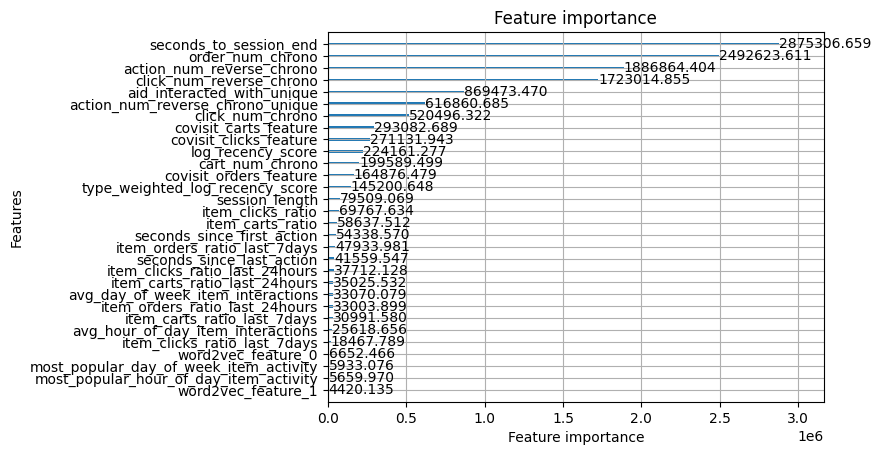

In [182]:
import lightgbm as lgb
lgb.plot_importance(ranker, importance_type="gain", max_num_features=30)


# Step 2: Model Inference

## Step 2.1: Loading testing data and pre-calculated co-visitation Matrix
For quicker experiment, we will only use 1/10 of the validation test_parquet 

We use another set of session to mimic the test set pattern. 

We extract a different set of sesion using the function  test_df[test_df['session']%10 == 0]

In [183]:
def load_test_data():    
    train_df = pd.read_parquet(f'{config.validation_path}test.parquet')
    # Using different sample as the candidate generation for training
    train_df = train_df[train_df['session']%10 == 0]
    return train_df

test_df = load_test_data()
print('Test data has shape',test_df.shape)
test_df.head()

Test data has shape (775199, 4)


,session,aid,ts,type
2,11098530,264500,1661119200,0
3,11098530,264500,1661119288,0
4,11098530,409236,1661119369,0
5,11098530,409236,1661119441,0
6,11098530,409236,1661120165,0


We have pre-calcaulted the covisitatioin matrix and saved them as the parquet file. Here we only load the result matrix from kaggle dataset to save time<br>
To understand how to generate the co-vistation matrix, you can see here:
https://www.kaggle.com/code/cdeotte/candidate-rerank-model-lb-0-575

In [184]:
%%time
top_clicks, top_orders = get_top_clicks_orders(test_df)
covisit_clicks = load_combined_covisitation(type="clicks")
covisit_carts_orders = load_combined_covisitation(type="carts-orders")
covisits_buy2buy = load_combined_covisitation(type="buy2buy")

Size of top_20_clicks: 1825950
Size of top_20_carts-orders: 1825950
Size of top_20_buy2buy: 1059692
CPU times: user 8.22 s, sys: 840 ms, total: 9.05 s
Wall time: 9.03 s


# Step 2.2 Candidate Generation using ReRank Model

Same logic with the candidate ReRank model. There is a changes made for the clicks suggestion (See the comment below)

In [185]:
top_carts = test_df.loc[test_df['type'] == 1,'aid'].value_counts().index.values[:20]

In [186]:
def suggest_clicks(df):
    # USER HISTORY AIDS AND TYPES
    aids=df.aid.tolist()
    types = df.type.tolist()
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    # RERANK CANDIDATES USING WEIGHTS
    if len(unique_aids)>=20:
        weights=np.logspace(0.1,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter()
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * config.type_weight[t]
        return [k for k,v in aids_temp.most_common(20)]
    # USE "CLICKS" CO-VISITATION MATRIX
    aids2 = list(itertools.chain(*[covisit_clicks[aid] for aid in unique_aids if aid in covisit_clicks]))
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2).most_common(20) if aid2 not in unique_aids]
    result = unique_aids + top_aids2[:20 - len(unique_aids)]
    # USE TOP20 TEST CLICKS
    return result + list(top_clicks)[:20-len(result)]

I have re-write the function and made the changes below

1. Changing recommended aid number from 20 to 40
The reason is that if only 20 is recommended, the ranker actually will not boost perofrmance since the LeaderBoard Recall score is calcualted **regardless** of the order. <br>
Therefore, here we recommnd more candidate to increase the **Recall metrics (i.e. Total coverage of ground truth aid that is recommeneded in the candidate recommendation)**

2. aid in test set will not be recommened
The aid in test set will be handled seperately since they have ts information and should not have CG_ranking (Candidate generation ranking) feature info.

In [187]:
top_clicks = test_df.loc[test_df['type']== 0,'aid'].value_counts().index.values[:40] 
def suggest_clicks_40_candidates(df):
    # USER HISTORY AIDS AND TYPES
    aids=df.aid.tolist()
    types = df.type.tolist()
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    # RERANK CANDIDATES USING WEIGHTS
    if len(unique_aids)>=40:
        weights=np.logspace(0.1,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter()
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * config.type_weight[t]
        return [k for k,v in aids_temp.most_common(40)]
    # USE "CLICKS" CO-VISITATION MATRIX
    aids2 = list(itertools.chain(*[covisit_clicks[aid] for aid in unique_aids if aid in covisit_clicks]))
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2).most_common(40) if aid2 not in unique_aids]
    result = top_aids2[:40]
    # USE TOP20 TEST CLICKS
    return result + list(top_clicks)[:40-len(result)]

In [188]:
def suggest_carts(df):
    # User history aids and types
    aids = df.aid.tolist()
    types = df.type.tolist()
    
    # UNIQUE AIDS AND UNIQUE BUYS
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    df = df.loc[(df['type'] == 0)|(df['type'] == 1)]
    unique_buys = list(dict.fromkeys(df.aid.tolist()[::-1]))
    
    # Rerank candidates using weights
    if len(unique_aids) >= 20:
        weights=np.logspace(0.5,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter() 
        
        # Rerank based on repeat items and types of items
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * config.type_weight[t]
        
        # Rerank candidates using"top_20_carts" co-visitation matrix
        aids2 = list(itertools.chain(*[covisit_carts_orders[aid] for aid in unique_buys if aid in covisit_carts_orders]))
        for aid in aids2: aids_temp[aid] += 0.1
        sorted_aids = [k for k,v in aids_temp.most_common(20)]
        return sorted_aids
    
    # Use "cart order" and "clicks" co-visitation matrices
    aids1 = list(itertools.chain(*[covisit_clicks[aid] for aid in unique_aids if aid in covisit_clicks]))
    aids2 = list(itertools.chain(*[covisit_carts_orders[aid]*2 for aid in unique_aids if aid in covisit_carts_orders]))
    
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids1+aids2).most_common(20) if aid2 not in unique_aids] 
    result = unique_aids + top_aids2[:20 - len(unique_aids)]
    
    # USE TOP20 TEST ORDERS

    return result + list(top_carts)[:20-len(result)]

In [189]:
def suggest_buys(df):
    # USER HISTORY AIDS AND TYPES
    aids=df.aid.tolist()
    types = df.type.tolist()
    # UNIQUE AIDS AND UNIQUE BUYS
    unique_aids = list(dict.fromkeys(aids[::-1] ))
    df = df.loc[(df['type']==1)|(df['type']==2)]
    unique_buys = list(dict.fromkeys( df.aid.tolist()[::-1] ))
    # RERANK CANDIDATES USING WEIGHTS
    if len(unique_aids)>=20:
        weights=np.logspace(0.5,1,len(aids),base=2, endpoint=True)-1
        aids_temp = Counter() 
        # RERANK BASED ON REPEAT ITEMS AND TYPE OF ITEMS
        for aid,w,t in zip(aids,weights,types): 
            aids_temp[aid] += w * config.type_weight[t]
        # RERANK CANDIDATES USING "BUY2BUY" CO-VISITATION MATRIX
        aids3 = list(itertools.chain(*[covisits_buy2buy[aid] for aid in unique_buys if aid in covisits_buy2buy]))
        for aid in aids3: aids_temp[aid] += 0.1
        sorted_aids = [k for k,v in aids_temp.most_common(25)]
        return sorted_aids
    # USE "CART ORDER" CO-VISITATION MATRIX
    aids2 = list(itertools.chain(*[covisit_carts_orders[aid] for aid in unique_aids if aid in covisit_carts_orders]))
    # USE "BUY2BUY" CO-VISITATION MATRIX
    aids3 = list(itertools.chain(*[covisits_buy2buy[aid] for aid in unique_buys if aid in covisits_buy2buy]))
    # RERANK CANDIDATES
    top_aids2 = [aid2 for aid2, cnt in Counter(aids2+aids3).most_common(30) if aid2 not in unique_aids] 
    result = unique_aids + top_aids2[:25 - len(unique_aids)]
    # USE TOP20 TEST ORDERS
    return result + list(top_orders)[:25 - len(result)]

### Generate candidates for each action using co-visitation matrix

In [190]:
%%time

# Improved speed for 2X using pandarallel
# pred_df_clicks = test_df.sort_values(["session", "ts"]).groupby(["session"]).parallel_apply(
#     lambda x: suggest_clicks(x)
# )

pred_df_buys = test_df.sort_values(["session", "ts"]).groupby(["session"]).parallel_apply(
    lambda x: suggest_buys(x)
)

# pred_df_carts = test_df.sort_values(["session", "ts"]).groupby(["session"]).parallel_apply(
#     lambda x: suggest_carts(x)
# )

CPU times: user 11.9 s, sys: 4.26 s, total: 16.1 s
Wall time: 24.8 s


# Step 2.3 Candidate Ranking using LGBM Ranker

To run the ranker, we need to combine two sources of data
1. aid provided by the test set
2. aid recommended in the candidate generation stage

These two types of aid should be handled seperately since some of their feature is different (e.g. aid from candidate generation does not haev ts information)

### Handle aid from test set

In [191]:
# Extracting the testing data action for clicks only
test_df_click = test_df[test_df['type'] == type_ranker]
test_df_click['real_action'] = 1
test_df_click['CG_ranking'] = 0

test_df_click = pl.from_pandas(test_df_click)

### Handle aid from candidate recommenedation

In [192]:
# Extracting the candiddate generated from the testing data
clicks_candidate_df = pl.from_pandas(pd.DataFrame(pred_df_buys, columns = ['aid']).reset_index())
clicks_candidate_df = clicks_candidate_df.explode('aid')
clicks_candidate_df = clicks_candidate_df.with_columns([
    pl.lit(0).alias('ts').cast(pl.Int32),    
    pl.lit(type_ranker).alias('type').cast(pl.Int8),
    pl.lit(0).alias('real_action').cast(pl.Int64),
    pl.col('session').cast(pl.Int32),
    pl.col('aid').cast(pl.Int32),
])
n_col_after_join = clicks_candidate_df.groupby('session').agg([
    pl.col('aid').cumcount().alias('CG_ranking')]).select(
    pl.col('CG_ranking').explode().cast(pl.Int64))

test_df_click_recommended = pl.concat([clicks_candidate_df, n_col_after_join], how="horizontal")


### Feature Calculation for inference data

In [193]:
test_df_click_recommended = test_df_click_recommended.with_column(
    pl.col('type').cast(pl.Int8),
)
test_df_click = test_df_click.with_column(
    pl.col('type').cast(pl.Int8),
)

In [194]:

# Calculating the feature on the inference data
test_df_click = test_df_click.join(aid_features, on = 'aid', how = 'left') \
                             .join(session_features, on = 'session', how = 'left') \
                             .join(user_item_features, on = ['session', 'aid'], how = 'left')
test_df_click_recommended = test_df_click_recommended.join(aid_features, on = 'aid', how = 'left') \
                            .join(session_features, on = 'session', how = 'left') \
                            .join(user_item_features, on = ['session', 'aid'], how = 'left')

# Combining the actual test data aid and recommended aid
test_df_click_all = pl.concat([test_df_click, test_df_click_recommended], how = 'vertical')

In [195]:
# Model inference
scores = ranker.predict(test_df_click_all[feature_cols].to_pandas())

# Appending the model score to the original dataframe
test_df_click_all = test_df_click_all.with_columns(pl.Series(name='score', values=scores))

In [196]:
# Getting the top 20 candidates from the prediction
orders_pred_df = test_df_click_all.sort(['session', 'score'], reverse=True).unique(subset=['session', 'aid']).groupby('session').agg([
    pl.col('aid').limit(20).list().alias('labels')
])

# Converting to pandas format and making it align with result format
orders_pred_df = orders_pred_df.with_columns(
pl.col('session') + '_orders'
).to_pandas()

# Step 2.4 Exporting to csv

In [197]:
clicks_pred_df = pd.DataFrame(pred_df_clicks.add_suffix("_clicks"), columns=["labels"]).reset_index()
# orders_pred_df = pd.DataFrame(pred_df_buys.add_suffix("_orders"), columns=["labels"]).reset_index()
carts_pred_df = pd.DataFrame(pred_df_carts.add_suffix("_carts"), columns=["labels"]).reset_index()

In [198]:
pred_df = pd.concat([clicks_pred_df, orders_pred_df, carts_pred_df])
pred_df.columns = ["session_type", "labels"]
pred_df["labels"] = pred_df.labels.apply(lambda x: " ".join(map(str,x)))
pred_df.to_csv("validation_preds.csv", index=False)
pred_df.head()

,session_type,labels
0,11098530_clicks,409236 264500 1603001 963957 254154 583026 167...
1,11098540_clicks,1545215 1043062 789082 1277598 1380694 131238 ...
2,11098550_clicks,1701345 71765 1602019 160619 1132460 1759865 1...
3,11098560_clicks,489962 1717976 1382757 1632920 1745620 67006 1...
4,11098570_clicks,873038 1787809 926999 1661296 1695413 583063 1...


# Step 3: Model Evaluation

This code is from Chris. It aims to calculate the local Recall score of the ranking. See the notebook link here: https://www.kaggle.com/code/cdeotte/compute-validation-score-cv-565

In [199]:
# # FREE MEMORY
# del pred_df_clicks, pred_df_buys, clicks_pred_df, orders_pred_df, carts_pred_df
# del top_20_clicks, top_20_buy2buy, top_20_buys, top_clicks, top_orders, test_df
# _ = gc.collect()

In [200]:
%%time
# COMPUTE METRIC
score = 0
weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}
for t in ['clicks','carts','orders']:
    sub = pred_df.loc[pred_df.session_type.str.contains(t)].copy()
    sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')])
    test_labels = pd.read_parquet(config.validation_path + 'test_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==t]
    test_labels = test_labels.merge(sub, how='left', on=['session'])
    test_labels = test_labels.dropna()
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    score += weights[t]*recall
    print(f'{t} recall =',recall)
    
print('=============')
print('Overall Recall =',score)
print('=============')

clicks recall = 0.5248338520114452
carts recall = 0.41239142822607106
orders recall = 0.6517831803992054
Overall Recall = 0.567270721908489
CPU times: user 7.52 s, sys: 532 ms, total: 8.06 s
Wall time: 7.75 s


### Previous performance of the ReRank Model

clicks recall = 0.3896982547336502 <br>
carts recall = 0.4105610333097339<br>
orders recall = 0.6519093116387601 <br>
=============<br>
Overall Recall = 0.5532837224495413 <br>
=============<br>


**The performance drop for the click behavior, we may need to optimize the model or put more weight to the aid of actual behavior.**

In [201]:
feature_cols

['avg_hour_of_day_item_interactions',
 'avg_day_of_week_item_interactions',
 'first_day_of_week_item_activity',
 'last_day_of_week_item_activity',
 'first_hour_of_item_activity',
 'last_hour_of_item_activity',
 'most_popular_day_of_week_item_activity',
 'most_popular_hour_of_day_item_activity',
 'item_clicks_ratio',
 'item_carts_ratio',
 'item_clicks_ratio_last_7days',
 'item_carts_ratio_last_7days',
 'item_orders_ratio_last_7days',
 'item_clicks_ratio_last_24hours',
 'item_carts_ratio_last_24hours',
 'item_orders_ratio_last_24hours',
 'day_of_week',
 'hour_of_the_day',
 'is_day',
 'avg_day_of_week_user_activity',
 'first_day_of_week_user_activity',
 'last_day_of_week_user_activity',
 'first_day_of_week_user_activity_right',
 'last_day_of_week_user_activity_right',
 'avg_hour_user_interactions',
 'first_hour_of_user_activity',
 'last_hour_of_user_activity',
 'avg_hour_in_each_real_session',
 'avg_items_in_each_real_session',
 'avg_time_between_clicks',
 'num_real_sessions',
 'num_day_e